In [ ]:
# Clean start and setup
!rm -rf /content/dl-project /content/outputs
!git clone https://github.com/GitKPOrg/dl-project.git /content/dl-project
!pip install -q transformers datasets sentence-transformers scikit-learn accelerate

print("✅ Setup complete!")

Cloning into '/content/dl-project'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 158 (delta 36), reused 61 (delta 25), pack-reused 70 (from 2)
Receiving objects: 100% (158/158), 57.99 MiB | 11.91 MiB/s, done.
Resolving deltas: 100% (51/51), done.
Updating files: 100% (49/49), done.
✅ Setup complete!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

BASE_DIR = "/content/drive/MyDrive/cs7643_project"   # or any name you like
VANILLA_DIR = os.path.join(BASE_DIR, "vanilla")

os.makedirs(VANILLA_DIR, exist_ok=True)

folders = {}
folders['vanilla'] = VANILLA_DIR

print("Vanilla outputs will be saved under:", folders['vanilla'])


Vanilla outputs will be saved under: /content/drive/MyDrive/cs7643_project/vanilla


In [ ]:
# Import all required libraries
import os
import sys
import random
import json
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from datetime import datetime
from collections import Counter
import re

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    ConfusionMatrixDisplay
)

warnings.filterwarnings('ignore')
os.environ["WANDB_DISABLED"] = "true"

# Add repo to path
sys.path.append('/content/dl-project/DL_Team_Project_Code_Files_Structure')

print("✅ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✅ All imports successful!
PyTorch version: 2.9.0+cu126
CUDA available: True


In [ ]:
# Set seed for reproducibility
SEED = 42

def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

    from transformers import set_seed as transformers_set_seed
    transformers_set_seed(seed)

    print(f"✅ All seeds set to {seed}")

set_all_seeds(SEED)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Device: {device}")

✅ All seeds set to 42
🖥️  Device: cuda


In [ ]:
# Create output folder structure
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
run_dir = f'/content/outputs/run_{timestamp}_seed{SEED}'

folders = {
    'base': run_dir,
    'vanilla': os.path.join(run_dir, 'vanilla'),
    'roberta': os.path.join(run_dir, 'roberta'),
    'sbert': os.path.join(run_dir, 'sbert'),
    'results': os.path.join(run_dir, 'results'),
    'visualizations': os.path.join(run_dir, 'visualizations'),
}

for folder in folders.values():
    os.makedirs(folder, exist_ok=True)

# Save config
config = {
    'seed': SEED,
    'timestamp': timestamp,
    'run_directory': run_dir
}

with open(os.path.join(run_dir, 'run_config.json'), 'w') as f:
    json.dump(config, f, indent=2)

print(f"📁 Outputs: {run_dir}")
print(f"✅ All folders created")

📁 Outputs: /content/outputs/run_20251209_042258_seed42
✅ All folders created


In [ ]:
# Load and prepare data
set_all_seeds(SEED)

print("📊 Loading data...")

data_path = '/content/dl-project/DL_Team_Project_Code_Files_Structure/data'
train_df = pd.read_csv(f'{data_path}/data_train.csv')
val_df = pd.read_csv(f'{data_path}/data_val.csv')
test_df = pd.read_csv(f'{data_path}/data_test.csv')

# Drop unnecessary columns
columns_to_drop = ['label5', 'lang']
train_df = train_df.drop(columns=columns_to_drop, errors='ignore')
val_df = val_df.drop(columns=columns_to_drop, errors='ignore')
test_df = test_df.drop(columns=columns_to_drop, errors='ignore')

print(f"\n✅ Dataset loaded:")
print(f"  Train: {len(train_df):,} samples")
print(f"  Val:   {len(val_df):,} samples")
print(f"  Test:  {len(test_df):,} samples")

# Show label distribution
print("\n📊 Label distribution (training):")
label_names = ['Negative', 'Neutral', 'Positive']
for label, count in train_df['label3'].value_counts().sort_index().items():
    pct = count / len(train_df) * 100
    print(f"  {label_names[label]:8s}: {count:,} ({pct:.1f}%)")

# Display sample
print("\n📝 Sample reviews:")
display(train_df[['text', 'rating', 'label3']].head(3))

✅ All seeds set to 42
📊 Loading data...

✅ Dataset loaded:
  Train: 200,000 samples
  Val:   20,000 samples
  Test:  20,000 samples

📊 Label distribution (training):
  Negative: 66,667 (33.3%)
  Neutral : 66,666 (33.3%)
  Positive: 66,667 (33.3%)

📝 Sample reviews:


,text,rating,label3
0,"Burned Skin — Smell is amazing, but totally bu...",2.0,0
1,Three Stars — I don't like that it doesn't hav...,3.0,1
2,"good clay for short, thick hair — i have very ...",5.0,2


In [ ]:
# Custom tokenizer for Vanilla Transformer
print("\n" + "="*70)
print("📝 BUILDING CUSTOM TOKENIZER")
print("="*70)

class SimpleTokenizer:
    """Simple word-level tokenizer for vanilla transformer"""

    def __init__(self, vocab_size=15000, max_len=256):
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.word2idx = {}
        self.idx2word = {}

        # Special tokens
        self.PAD_TOKEN = '<PAD>'
        self.UNK_TOKEN = '<UNK>'
        self.CLS_TOKEN = '<CLS>'

        self.pad_idx = 0
        self.unk_idx = 1
        self.cls_idx = 2

    def build_vocab(self, texts):
        """Build vocabulary from training texts"""
        print("Building vocabulary from training data...")

        # Count all words
        word_counts = Counter()
        for text in texts:
            words = self._tokenize(text)
            word_counts.update(words)

        # Get most common words
        most_common = word_counts.most_common(self.vocab_size - 3)

        # Build vocabulary
        self.word2idx = {
            self.PAD_TOKEN: self.pad_idx,
            self.UNK_TOKEN: self.unk_idx,
            self.CLS_TOKEN: self.cls_idx
        }

        for idx, (word, _) in enumerate(most_common, start=3):
            self.word2idx[word] = idx

        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

        # Calculate coverage
        total_words = sum(word_counts.values())
        covered_words = sum([c for _, c in most_common])
        coverage = covered_words / total_words * 100

        print(f"✅ Vocabulary built: {len(self.word2idx):,} words")
        print(f"✅ Coverage: {coverage:.1f}%")

    def _tokenize(self, text):
        """Simple word tokenization"""
        text = text.lower()
        text = re.sub(r'[^a-zA-Z0-9\\s]', '', text)
        return text.split()

    def encode(self, text):
        """Convert text to token IDs"""
        words = self._tokenize(text)

        # Add CLS token and convert to IDs
        token_ids = [self.cls_idx]
        token_ids.extend([self.word2idx.get(word, self.unk_idx) for word in words])

        # Truncate or pad to max_len
        if len(token_ids) > self.max_len:
            token_ids = token_ids[:self.max_len]
        else:
            padding = [self.pad_idx] * (self.max_len - len(token_ids))
            token_ids.extend(padding)

        return token_ids

# Build tokenizer
vanilla_tokenizer = SimpleTokenizer(vocab_size=15000, max_len=256)
vanilla_tokenizer.build_vocab(train_df['text'].tolist())

print(f"\n✅ Tokenizer ready: {len(vanilla_tokenizer.word2idx):,} tokens")


📝 BUILDING CUSTOM TOKENIZER
Building vocabulary from training data...
✅ Vocabulary built: 15,000 words
✅ Coverage: 23.7%

✅ Tokenizer ready: 15,000 tokens


In [ ]:
# Vanilla Transformer Architecture
print("\n" + "="*70)
print("🏗️  VANILLA TRANSFORMER ARCHITECTURE")
print("="*70)

class PositionalEncoding(nn.Module):
    """Sinusoidal positional encoding"""

    def __init__(self, d_model, max_len=512, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Add batch dimension

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


class MultiHeadAttention(nn.Module):
    """Multi-head self-attention mechanism"""

    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        # Linear projections
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        batch_size = x.size(0)

        # Linear projections and reshape for multi-head
        Q = self.W_q(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attention = F.softmax(scores, dim=-1)
        attention = self.dropout(attention)

        # Apply attention to values
        context = torch.matmul(attention, V)

        # Concatenate heads and apply final linear
        context = context.transpose(1, 2).contiguous()
        context = context.view(batch_size, -1, self.d_model)
        output = self.W_o(context)

        return output


class FeedForward(nn.Module):
    """Position-wise feed-forward network"""

    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x


class TransformerEncoderLayer(nn.Module):
    """Single transformer encoder layer with self-attention and feed-forward"""

    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        # Multi-head attention
        self.attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)

        # Feed-forward
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Multi-head attention with residual connection
        attn_output = self.attention(x, mask)
        x = self.norm1(x + self.dropout1(attn_output))

        # Feed-forward with residual connection
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout2(ff_output))

        return x


class VanillaTransformer(nn.Module):
    """Complete vanilla transformer for sentiment classification"""

    def __init__(
        self,
        vocab_size,
        d_model=256,
        num_heads=8,
        num_layers=4,
        d_ff=1024,
        max_len=256,
        num_classes=3,
        dropout=0.1
    ):
        super().__init__()
        self.d_model = d_model

        # Embedding and positional encoding
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len, dropout)

        # Transformer encoder layers
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, num_classes)
        )

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize weights using Xavier uniform"""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x, mask=None):
        # Embedding with scaling
        x = self.embedding(x) * np.sqrt(self.d_model)
        x = self.pos_encoding(x)

        # Pass through encoder layers
        for layer in self.encoder_layers:
            x = layer(x, mask)

        # Global average pooling
        x = x.mean(dim=1)

        # Classification
        logits = self.classifier(x)

        return logits

print("✅ Vanilla Transformer architecture defined")


🏗️  VANILLA TRANSFORMER ARCHITECTURE
✅ Vanilla Transformer architecture defined


In [ ]:
# Create PyTorch datasets and dataloaders
print("\n" + "="*70)
print("📦 CREATING DATASETS")
print("="*70)

class SentimentDataset(Dataset):
    """Custom dataset for sentiment classification"""

    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize text
        token_ids = self.tokenizer.encode(text)

        return {
            'input_ids': torch.tensor(token_ids, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
train_dataset_vanilla = SentimentDataset(
    train_df['text'].tolist(),
    train_df['label3'].tolist(),
    vanilla_tokenizer
)

val_dataset_vanilla = SentimentDataset(
    val_df['text'].tolist(),
    val_df['label3'].tolist(),
    vanilla_tokenizer
)

test_dataset_vanilla = SentimentDataset(
    test_df['text'].tolist(),
    test_df['label3'].tolist(),
    vanilla_tokenizer
)

# Create dataloaders
train_loader_vanilla = DataLoader(
    train_dataset_vanilla,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

val_loader_vanilla = DataLoader(
    val_dataset_vanilla,
    batch_size=64,
    shuffle=False,
    num_workers=0
)

test_loader_vanilla = DataLoader(
    test_dataset_vanilla,
    batch_size=64,
    shuffle=False,
    num_workers=0
)

print(f"✅ Datasets created:")
print(f"  Train: {len(train_dataset_vanilla):,} samples")
print(f"  Val:   {len(val_dataset_vanilla):,} samples")
print(f"  Test:  {len(test_dataset_vanilla):,} samples")


📦 CREATING DATASETS
✅ Datasets created:
  Train: 200,000 samples
  Val:   20,000 samples
  Test:  20,000 samples


In [ ]:
import os
import time
import json

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from sklearn.metrics import accuracy_score, precision_recall_fscore_support


print("\n" + "="*70)
print("📦 CREATING DATASETS")
print("="*70)


# ==============================
# Dataset definition
# ==============================

class SentimentDataset(Dataset):
    """Custom dataset for sentiment classification"""

    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize text
        token_ids = self.tokenizer.encode(text)

        return {
            'input_ids': torch.tensor(token_ids, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }


# ==============================
# Create full datasets & loaders
# ==============================

train_dataset_vanilla = SentimentDataset(
    train_df['text'].tolist(),
    train_df['label3'].tolist(),
    vanilla_tokenizer
)

val_dataset_vanilla = SentimentDataset(
    val_df['text'].tolist(),
    val_df['label3'].tolist(),
    vanilla_tokenizer
)

test_dataset_vanilla = SentimentDataset(
    test_df['text'].tolist(),
    test_df['label3'].tolist(),
    vanilla_tokenizer
)

train_loader_vanilla = DataLoader(
    train_dataset_vanilla,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

val_loader_vanilla = DataLoader(
    val_dataset_vanilla,
    batch_size=64,
    shuffle=False,
    num_workers=0
)

test_loader_vanilla = DataLoader(
    test_dataset_vanilla,
    batch_size=64,
    shuffle=False,
    num_workers=0
)

print(f"✅ Datasets created:")
print(f"  Train: {len(train_dataset_vanilla):,} samples")
print(f"  Val:   {len(val_dataset_vanilla):,} samples")
print(f"  Test:  {len(test_dataset_vanilla):,} samples")


# ==============================
# Vanilla Transformer config
# ==============================

print("\n" + "="*70)
print("🚀 TRAINING VANILLA TRANSFORMER (FROM SCRATCH)")
print("="*70)

set_all_seeds(SEED)

VANILLA_CONFIG = {
    'vocab_size': len(vanilla_tokenizer.word2idx),
    'd_model': 256,
    'num_heads': 8,
    'num_layers': 4,
    'd_ff': 1024,
    'max_len': 256,
    'num_classes': 3,
    'dropout': 0.1,
    'batch_size': 32,
    'epochs': 5,
    'learning_rate': 5e-4,
    'warmup_steps': 500,
}

print("\n📋 Configuration:")
for k, v in VANILLA_CONFIG.items():
    print(f"  {k:20s}: {v}")


# ==============================
# Training function (with warmup)
# ==============================

def train_vanilla_complete(model, train_loader, val_loader, config, device):
    """Complete training function with warmup scheduler"""

    optimizer = AdamW(
        model.parameters(),
        lr=config['learning_rate'],
        weight_decay=0.01
    )
    criterion = nn.CrossEntropyLoss()

    total_steps = len(train_loader) * config['epochs']
    warmup_steps = config['warmup_steps']

    def lr_lambda(step):
        if step < warmup_steps:
            # Linear warmup
            return float(step) / float(max(1, warmup_steps))
        # Linear decay
        return max(
            0.0,
            float(total_steps - step) / float(max(1, total_steps - warmup_steps))
        )

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': []
    }
    best_f1 = 0.0

    print("\n🚀 Starting training...")
    print("="*70)

    global_step = 0

    for epoch in range(config['epochs']):
        # ==========================
        # Training phase
        # ==========================
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, batch in enumerate(train_loader):
            inputs = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            scheduler.step()
            global_step += 1

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

            if (batch_idx + 1) % 200 == 0:
                batch_acc = correct / total
                print(
                    f"Epoch {epoch+1}/{config['epochs']} | "
                    f"Batch {batch_idx+1}/{len(train_loader)} | "
                    f"Loss: {loss.item():.4f} | "
                    f"Acc: {batch_acc:.4f}"
                )

        train_acc = correct / total

        # ==========================
        # Validation phase
        # ==========================
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for batch in val_loader:
                inputs = batch['input_ids'].to(device)
                labels = batch['label'].to(device)

                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()

                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)
        _, _, val_f1, _ = precision_recall_fscore_support(
            val_labels,
            val_preds,
            average='weighted',
            zero_division=0
        )

        history['train_loss'].append(train_loss / len(train_loader))
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        print(f"\n{'='*70}")
        print(
            f"Epoch {epoch+1}: "
            f"Train Acc={train_acc:.4f} | "
            f"Val Acc={val_acc:.4f} | "
            f"Val F1={val_f1:.4f}"
        )
        print(f"{'='*70}\n")

        # Save best model for THIS run (caller can name path if needed)
        if val_f1 > best_f1:
            best_f1 = val_f1

    return model, history, best_f1


# ==============================
# Evaluation helper
# ==============================

# def evaluate_model(model, data_loader, device):
#     """Evaluate model on a given dataloader"""
#     model.eval()
#     criterion = nn.CrossEntropyLoss()

#     total_loss = 0.0
#     all_preds = []
#     all_labels = []

#     with torch.no_grad():
#         for batch in data_loader:
#             inputs = batch['input_ids'].to(device)
#             labels = batch['label'].to(device)

#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             total_loss += loss.item()

#             _, preds = torch.max(outputs, 1)
#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#     avg_loss = total_loss / len(data_loader)
#     acc = accuracy_score(all_labels, all_preds)
#     _, _, f1, _ = precision_recall_fscore_support(
#         all_labels, all_preds,
#         average='weighted',
#         zero_division=0
#     )

#     return avg_loss, acc, f1
from sklearn.metrics import accuracy_score, f1_score, classification_report

def evaluate_model(model, data_loader, device):
    """
    Evaluation helper for the *vanilla* transformer:

    - Expects batches with keys: 'input_ids', 'label'
    - Model is called as: model(inputs)
    - Returns: avg_loss, accuracy, macro F1, per-class F1 array
    """
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0.0
    n_batches = 0

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch["input_ids"].to(device)
            labels = batch["label"].to(device)

            logits = model(inputs)  # VanillaTransformer returns logits directly
            loss = criterion(logits, labels)

            total_loss += loss.item()
            n_batches += 1

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / max(1, n_batches)
    acc = accuracy_score(all_labels, all_preds)

    # per-class F1: array [F1_class0, F1_class1, F1_class2]
    f1_per_class = f1_score(all_labels, all_preds, average=None)
    f1_macro = f1_score(all_labels, all_preds, average="macro")

    print("\n📊 Test classification report:")
    print(classification_report(all_labels, all_preds, digits=4))

    return avg_loss, acc, f1_macro, f1_per_class



📦 CREATING DATASETS
✅ Datasets created:
  Train: 200,000 samples
  Val:   20,000 samples
  Test:  20,000 samples

🚀 TRAINING VANILLA TRANSFORMER (FROM SCRATCH)
✅ All seeds set to 42

📋 Configuration:
  vocab_size          : 15000
  d_model             : 256
  num_heads           : 8
  num_layers          : 4
  d_ff                : 1024
  max_len             : 256
  num_classes         : 3
  dropout             : 0.1
  batch_size          : 32
  epochs              : 5
  learning_rate       : 0.0005
  warmup_steps        : 500


In [ ]:


# # ==============================
# # Data-efficiency experiment
# # ==============================

# print("\n" + "="*70)
# print("📉 DATA EFFICIENCY EXPERIMENT – VANILLA TRANSFORMER")
# print("="*70)

# sample_sizes = [100_000, 50_000, 20_000, 5_000, 1_000]
# results_vanilla = []

# for n in sample_sizes:
#     n_eff = min(n, len(train_df))
#     print(f"\n{'-'*70}")
#     print(f"🧪 Training with {n_eff:,} samples (requested: {n:,})")
#     print(f"{'-'*70}")

#     # Subsample training data
#     train_subset_df = train_df.sample(n=n_eff, random_state=SEED)

#     train_subset_dataset = SentimentDataset(
#         train_subset_df['text'].tolist(),
#         train_subset_df['label3'].tolist(),
#         vanilla_tokenizer
#     )

#     train_subset_loader = DataLoader(
#         train_subset_dataset,
#         batch_size=VANILLA_CONFIG['batch_size'],
#         shuffle=True,
#         num_workers=0
#     )

#     # New model from scratch
#     set_all_seeds(SEED)
#     vanilla_model_small = VanillaTransformer(
#         vocab_size=VANILLA_CONFIG['vocab_size'],
#         d_model=VANILLA_CONFIG['d_model'],
#         num_heads=VANILLA_CONFIG['num_heads'],
#         num_layers=VANILLA_CONFIG['num_layers'],
#         d_ff=VANILLA_CONFIG['d_ff'],
#         max_len=VANILLA_CONFIG['max_len'],
#         num_classes=VANILLA_CONFIG['num_classes'],
#         dropout=VANILLA_CONFIG['dropout']
#     ).to(device)

#     start_time = time.time()
#     vanilla_model_small, history_small, best_val_f1 = train_vanilla_complete(
#         vanilla_model_small,
#         train_subset_loader,
#         val_loader_vanilla,
#         VANILLA_CONFIG,
#         device
#     )
#     train_minutes = (time.time() - start_time) / 60

#     # Save per-epoch history for this train size
#     per_size_history_path = os.path.join(
#         folders['vanilla'],
#         f"history_train_{n_eff}.json"
#     )
#     with open(per_size_history_path, 'w') as f:
#         json.dump(
#             {k: [float(vv) for vv in v] for k, v in history_small.items()},
#             f,
#             indent=2
#         )

#     # Evaluate on full test set
#     test_loss, test_acc, test_f1 = evaluate_model(
#         vanilla_model_small,
#         test_loader_vanilla,
#         device
#     )

#     # Optionally save model per size
#     model_path_small = os.path.join(
#         folders['vanilla'],
#         f"best_model_train_{n_eff}.pth"
#     )
#     torch.save(vanilla_model_small.state_dict(), model_path_small)

#     print(f"\n✅ Finished {n_eff:,} samples:")
#     print(f"   Best Val F1 : {best_val_f1:.4f}")
#     print(f"   Test Acc    : {test_acc:.4f}")
#     print(f"   Test F1     : {test_f1:.4f}")
#     print(f"   Train time  : {train_minutes:.2f} min")
#     print(f"   📁 History  : {per_size_history_path}")
#     print(f"   📁 Model    : {model_path_small}")

#     results_vanilla.append({
#         'train_size_requested': int(n),
#         'train_size_used': int(n_eff),
#         'best_val_f1': float(best_val_f1),
#         'test_acc': float(test_acc),
#         'test_f1': float(test_f1),
#         'train_time_min': float(train_minutes),
#         'history_path': per_size_history_path,
#         'model_path': model_path_small,
#     })

# # Save master data-efficiency metrics
# results_path = os.path.join(folders['vanilla'], 'data_efficiency_results.json')
# with open(results_path, 'w') as f:
#     json.dump(results_vanilla, f, indent=2)

# print("\n📊 Data efficiency results saved to:", results_path)
# print("🎉 All experiments done.")



📉 DATA EFFICIENCY EXPERIMENT – VANILLA TRANSFORMER

----------------------------------------------------------------------
🧪 Training with 100,000 samples (requested: 100,000)
----------------------------------------------------------------------
✅ All seeds set to 42

🚀 Starting training...
Epoch 1/5 | Batch 200/3125 | Loss: 1.1072 | Acc: 0.3305
Epoch 1/5 | Batch 400/3125 | Loss: 1.0047 | Acc: 0.3618
Epoch 1/5 | Batch 600/3125 | Loss: 1.0309 | Acc: 0.4088
Epoch 1/5 | Batch 800/3125 | Loss: 0.7994 | Acc: 0.4325
Epoch 1/5 | Batch 1000/3125 | Loss: 1.0397 | Acc: 0.4459
Epoch 1/5 | Batch 1200/3125 | Loss: 0.8963 | Acc: 0.4585
Epoch 1/5 | Batch 1400/3125 | Loss: 1.1630 | Acc: 0.4630
Epoch 1/5 | Batch 1600/3125 | Loss: 0.9787 | Acc: 0.4696
Epoch 1/5 | Batch 1800/3125 | Loss: 0.8656 | Acc: 0.4754
Epoch 1/5 | Batch 2000/3125 | Loss: 1.0276 | Acc: 0.4794
Epoch 1/5 | Batch 2200/3125 | Loss: 1.0130 | Acc: 0.4820
Epoch 1/5 | Batch 2400/3125 | Loss: 0.8642 | Acc: 0.4848
Epoch 1/5 | Batch 2600/312

In [ ]:
# ==============================
# Data-efficiency experiment
# ==============================

print("\n" + "="*70)
print("📉 DATA EFFICIENCY EXPERIMENT – VANILLA TRANSFORMER")
print("="*70)

sample_sizes = [100_000, 50_000, 20_000, 5_000, 1_000]
results_vanilla = []

for n in sample_sizes:
    n_eff = min(n, len(train_df))
    print(f"\n{'-'*70}")
    print(f"🧪 Training with {n_eff:,} samples (requested: {n:,})")
    print(f"{'-'*70}")

    # Subsample training data
    train_subset_df = train_df.sample(n=n_eff, random_state=SEED)

    train_subset_dataset = SentimentDataset(
        train_subset_df['text'].tolist(),
        train_subset_df['label3'].tolist(),
        vanilla_tokenizer
    )

    train_subset_loader = DataLoader(
        train_subset_dataset,
        batch_size=VANILLA_CONFIG['batch_size'],
        shuffle=True,
        num_workers=0
    )

    # New model from scratch
    set_all_seeds(SEED)
    vanilla_model_small = VanillaTransformer(
        vocab_size=VANILLA_CONFIG['vocab_size'],
        d_model=VANILLA_CONFIG['d_model'],
        num_heads=VANILLA_CONFIG['num_heads'],
        num_layers=VANILLA_CONFIG['num_layers'],
        d_ff=VANILLA_CONFIG['d_ff'],
        max_len=VANILLA_CONFIG['max_len'],
        num_classes=VANILLA_CONFIG['num_classes'],
        dropout=VANILLA_CONFIG['dropout']
    ).to(device)

    start_time = time.time()
    vanilla_model_small, history_small, best_val_f1 = train_vanilla_complete(
        vanilla_model_small,
        train_subset_loader,
        val_loader_vanilla,
        VANILLA_CONFIG,
        device
    )
    train_minutes = (time.time() - start_time) / 60

    # Save per-epoch history for this train size
    per_size_history_path = os.path.join(
        folders['vanilla'],
        f"history_train_{n_eff}.json"
    )
    with open(per_size_history_path, 'w') as f:
        json.dump(
            {k: [float(vv) for vv in v] for k, v in history_small.items()},
            f,
            indent=2
        )

    # Evaluate on full test set  🔻 UPDATED: now returns per-class F1
    test_loss, test_acc, test_f1_macro, f1_per_class = evaluate_model(
        vanilla_model_small,
        test_loader_vanilla,
        device
    )

    # Optionally save model per size
    model_path_small = os.path.join(
        folders['vanilla'],
        f"best_model_train_{n_eff}.pth"
    )
    torch.save(vanilla_model_small.state_dict(), model_path_small)

    print(f"\n✅ Finished {n_eff:,} samples:")
    print(f"   Best Val F1      : {best_val_f1:.4f}")
    print(f"   Test Loss        : {test_loss:.4f}")
    print(f"   Test Acc         : {test_acc:.4f}")
    print(f"   Test F1 (macro)  : {test_f1_macro:.4f}")
    print(f"   Test F1 class 0  : {f1_per_class[0]:.4f}")
    print(f"   Test F1 class 1  : {f1_per_class[1]:.4f}")
    print(f"   Test F1 class 2  : {f1_per_class[2]:.4f}")
    print(f"   Train time       : {train_minutes:.2f} min")
    print(f"   📁 History       : {per_size_history_path}")
    print(f"   📁 Model         : {model_path_small}")

    results_vanilla.append({
        'train_size_requested': int(n),
        'train_size_used': int(n_eff),
        'best_val_f1': float(best_val_f1),
        'test_loss': float(test_loss),
        'test_acc': float(test_acc),
        'test_f1_macro': float(test_f1_macro),
        'f1_class_0': float(f1_per_class[0]),
        'f1_class_1': float(f1_per_class[1]),
        'f1_class_2': float(f1_per_class[2]),
        'train_time_min': float(train_minutes),
        'history_path': per_size_history_path,
        'model_path': model_path_small,
    })

# Save master data-efficiency metrics
results_path = os.path.join(folders['vanilla'], 'data_efficiency_results.json')
with open(results_path, 'w') as f:
    json.dump(results_vanilla, f, indent=2)

print("\n📊 Data efficiency results saved to:", results_path)
print("🎉 All experiments done.")


chart

In [ ]:
import json
import os
import pandas as pd

# Load results
results_path = os.path.join(folders['vanilla'], 'data_efficiency_results.json')

with open(results_path, 'r') as f:
    results = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(results)

# Sort by training size
df = df.sort_values("train_size_used")

# Select & rename columns for clean display
df_display = df[[
    "train_size_used",
    "best_val_f1",
    "test_acc",
    "test_f1",
    "train_time_min"
]].copy()

df_display = df_display.rename(columns={
    "train_size_used": "Train Size",
    "best_val_f1": "Best Val F1",
    "test_acc": "Test Accuracy",
    "test_f1": "Test F1",
    "train_time_min": "Training Time (min)"
})

# Add human-friendly size labels
df_display["Train Size"] = df_display["Train Size"].apply(
    lambda x: f"{int(x/1000)}k" if x >= 1000 else str(x)
)

# Round for nice printing
df_display["Best Val F1"] = df_display["Best Val F1"].round(4)
df_display["Test Accuracy"] = df_display["Test Accuracy"].round(4)
df_display["Test F1"] = df_display["Test F1"].round(4)
df_display["Training Time (min)"] = df_display["Training Time (min)"].round(2)

print("\n📊 Vanilla Transformer – Metrics vs Training Size\n")
print(df_display.to_string(index=False))



📊 Vanilla Transformer – Metrics vs Training Size

Train Size  Best Val F1  Test Accuracy  Test F1  Training Time (min)
        1k       0.5633         0.2226   0.0811                 1.73
        5k       0.0811         0.2226   0.0811                 2.63
       20k       0.0811         0.2226   0.0811                 6.00
       50k       0.5632         0.6898   0.5632                12.72
      100k       0.5643         0.6888   0.5638                25.44


In [ ]:
import os
import json
import pandas as pd

# The sizes you experimented with
train_sizes = [1000, 5000, 20000, 50000, 100000]

for n in train_sizes:
    history_path = os.path.join(
        folders['vanilla'],
        f"history_train_{n}.json"
    )

    if not os.path.exists(history_path):
        print(f"❌ Missing history file for {n}: {history_path}")
        continue

    # Load history
    with open(history_path, "r") as f:
        hist = json.load(f)

    epochs = list(range(1, len(hist["train_loss"]) + 1))

    # Build per-epoch DataFrame
    df_epoch = pd.DataFrame({
        "Epoch": epochs,
        "Train Loss": hist["train_loss"],
        "Validation Loss": hist["val_loss"],
        "Train Accuracy": hist["train_acc"],
        "Validation Accuracy": hist["val_acc"],
        "Validation F1": hist["val_f1"],
    })

    # Round for clean reporting
    df_epoch["Train Loss"] = df_epoch["Train Loss"].round(6)
    df_epoch["Validation Loss"] = df_epoch["Validation Loss"].round(6)
    df_epoch["Train Accuracy"] = df_epoch["Train Accuracy"].round(4)
    df_epoch["Validation Accuracy"] = df_epoch["Validation Accuracy"].round(4)
    df_epoch["Validation F1"] = df_epoch["Validation F1"].round(4)

    # Save to CSV
    out_path = os.path.join(
        folders['vanilla'],
        f"epoch_metrics_{n}.csv"
    )

    df_epoch.to_csv(out_path, index=False)

    print(f"✅ Saved per-epoch metrics for {n} samples → {out_path}")



✅ Saved per-epoch metrics for 1000 samples → /content/outputs/run_20251208_070702_seed42/vanilla/epoch_metrics_1000.csv
✅ Saved per-epoch metrics for 5000 samples → /content/outputs/run_20251208_070702_seed42/vanilla/epoch_metrics_5000.csv
✅ Saved per-epoch metrics for 20000 samples → /content/outputs/run_20251208_070702_seed42/vanilla/epoch_metrics_20000.csv
✅ Saved per-epoch metrics for 50000 samples → /content/outputs/run_20251208_070702_seed42/vanilla/epoch_metrics_50000.csv
✅ Saved per-epoch metrics for 100000 samples → /content/outputs/run_20251208_070702_seed42/vanilla/epoch_metrics_100000.csv


In [ ]:
import os
import json
import torch
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# ---------------------------------------------------
# 1. Load scaling results (with paths per train size)
# ---------------------------------------------------
results_path = os.path.join(folders['vanilla'], 'data_efficiency_results.json')

with open(results_path, 'r') as f:
    results = json.load(f)

# Sort by actual training size
results = sorted(results, key=lambda x: x['train_size_used'])

# ---------------------------------------------------
# 2. Helper: evaluate model on test set
# ---------------------------------------------------
def eval_on_test(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        all_labels,
        all_preds,
        average='weighted',
        zero_division=0
    )
    return acc, prec, rec, f1

# ---------------------------------------------------
# 3. Build summary rows for each train size
# ---------------------------------------------------
rows = []

for r in results:
    n = int(r['train_size_used'])
    history_path = r['history_path']
    model_path = r['model_path']

    # Load per-epoch history
    with open(history_path, 'r') as f:
        hist = json.load(f)

    # Last-epoch train/val loss
    train_loss_last = hist['train_loss'][-1]
    val_loss_last = hist['val_loss'][-1]

    # Reload model
    model = VanillaTransformer(
        vocab_size=VANILLA_CONFIG['vocab_size'],
        d_model=VANILLA_CONFIG['d_model'],
        num_heads=VANILLA_CONFIG['num_heads'],
        num_layers=VANILLA_CONFIG['num_layers'],
        d_ff=VANILLA_CONFIG['d_ff'],
        max_len=VANILLA_CONFIG['max_len'],
        num_classes=VANILLA_CONFIG['num_classes'],
        dropout=VANILLA_CONFIG['dropout']
    ).to(device)

    state = torch.load(model_path, map_location=device)
    model.load_state_dict(state)

    # Evaluate on test set
    test_acc, test_prec, test_rec, test_f1 = eval_on_test(
        model,
        test_loader_vanilla,
        device
    )

    rows.append({
        "Train Size Used": n,
        "Train Loss (last epoch)": float(train_loss_last),
        "Val Loss (last epoch)": float(val_loss_last),
        "Test Accuracy": float(test_acc),
        "Test Precision": float(test_prec),
        "Test Recall": float(test_rec),
        "Test F1": float(test_f1),
    })

# ---------------------------------------------------
# 4. Make a nice chart (DataFrame) and save
# ---------------------------------------------------
df = pd.DataFrame(rows).sort_values("Train Size Used")

# Human-friendly labels like 1k, 5k, 20k, 50k, 100k
df.insert(
    0,
    "Train Size",
    df["Train Size Used"].apply(lambda x: f"{int(x/1000)}k" if x >= 1000 else str(x))
)

# Round metrics for display
df["Train Loss (last epoch)"] = df["Train Loss (last epoch)"].round(4)
df["Val Loss (last epoch)"] = df["Val Loss (last epoch)"].round(4)
df["Test Accuracy"] = df["Test Accuracy"].round(4)
df["Test Precision"] = df["Test Precision"].round(4)
df["Test Recall"] = df["Test Recall"].round(4)
df["Test F1"] = df["Test F1"].round(4)

print("\n📊 Vanilla Transformer – Metrics by Training Size (Test Set Metrics)\n")
print(df.to_string(index=False))

# Save to CSV for later use (Excel / LaTeX)
csv_path = os.path.join(folders['vanilla'], "vanilla_all_metrics_by_train_size.csv")
df.to_csv(csv_path, index=False)
print("\n💾 CSV saved to:")
print(csv_path)



📊 Vanilla Transformer – Metrics by Training Size (Test Set Metrics)

Train Size  Train Size Used  Train Loss (last epoch)  Val Loss (last epoch)  Test Accuracy  Test Precision  Test Recall  Test F1
        1k             1000                   1.1235                 1.0922         0.2226          0.0496       0.2226   0.0811
        5k             5000                   1.0989                 1.0963         0.2226          0.0496       0.2226   0.0811
       20k            20000                   1.0986                 1.1038         0.2226          0.0496       0.2226   0.0811
       50k            50000                   1.0986                 1.0959         0.6898          0.4759       0.6898   0.5632
      100k           100000                   0.9426                 0.9372         0.6888          0.4898       0.6888   0.5638

💾 CSV saved to:
/content/outputs/run_20251208_070702_seed42/vanilla/vanilla_all_metrics_by_train_size.csv


plot

In [ ]:
import json
import os
import matplotlib.pyplot as plt

# Path to your saved results
results_path = os.path.join(
    folders['vanilla'],
    'data_efficiency_results.json'
)

with open(results_path, 'r') as f:
    results = json.load(f)

# Sort by training size (important for clean plots)
results = sorted(results, key=lambda x: x['train_size_used'])

train_sizes = [r['train_size_used'] for r in results]
best_val_f1 = [r['best_val_f1'] for r in results]
test_f1 = [r['test_f1'] for r in results]
train_time = [r['train_time_min'] for r in results]


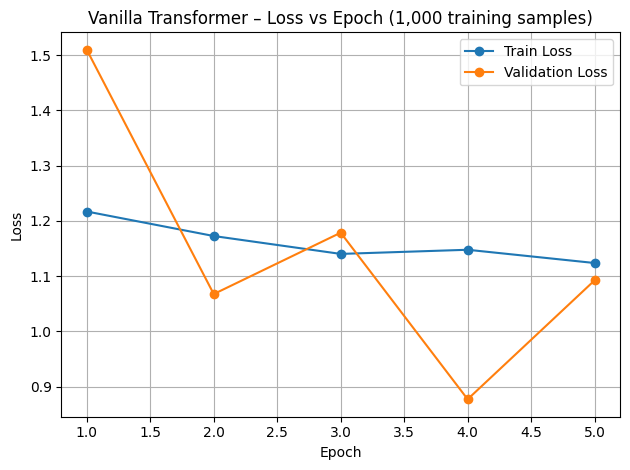

Saved: /content/outputs/run_20251208_070702_seed42/vanilla/loss_curves_train_1000.png


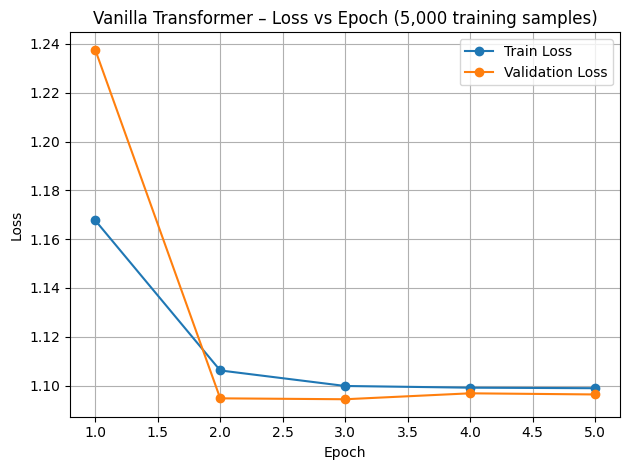

Saved: /content/outputs/run_20251208_070702_seed42/vanilla/loss_curves_train_5000.png


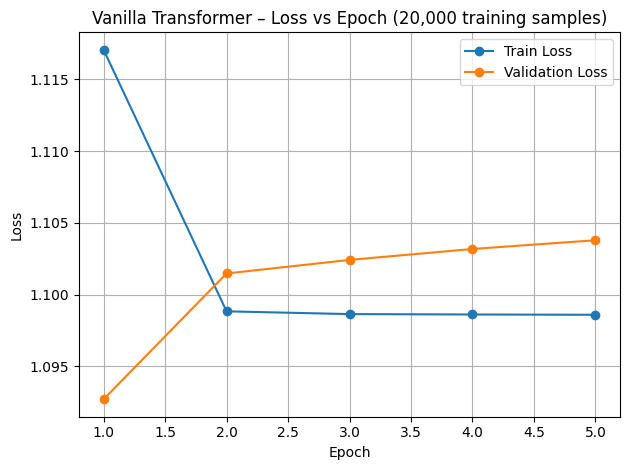

Saved: /content/outputs/run_20251208_070702_seed42/vanilla/loss_curves_train_20000.png


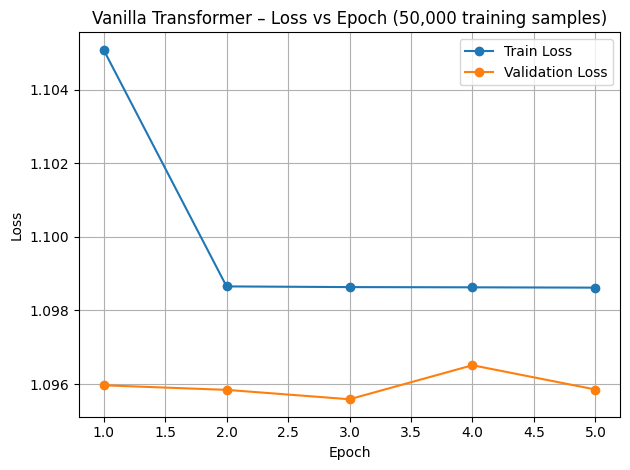

Saved: /content/outputs/run_20251208_070702_seed42/vanilla/loss_curves_train_50000.png


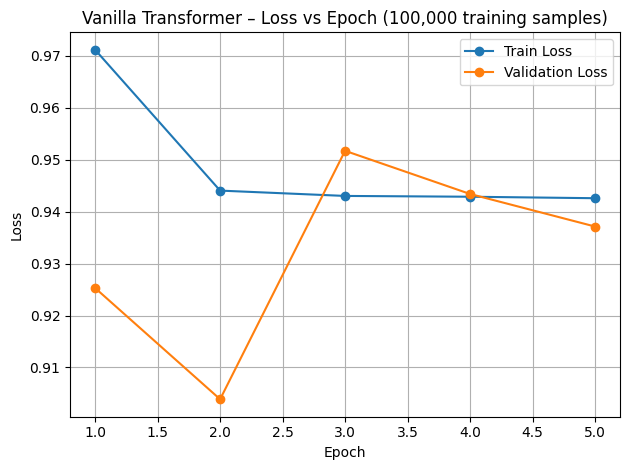

Saved: /content/outputs/run_20251208_070702_seed42/vanilla/loss_curves_train_100000.png


In [ ]:
import os
import json
import matplotlib.pyplot as plt

# Load overall results (has history_path for each size)
results_path = os.path.join(folders['vanilla'], 'data_efficiency_results.json')

with open(results_path, 'r') as f:
    results = json.load(f)

# Sort by training size for consistency
results = sorted(results, key=lambda x: x['train_size_used'])

for r in results:
    n = int(r['train_size_used'])
    history_path = r['history_path']

    # Load history for this model
    with open(history_path, 'r') as f:
        hist = json.load(f)

    train_loss = hist['train_loss']
    val_loss = hist['val_loss']
    epochs = list(range(1, len(train_loss) + 1))

    # Make a separate figure for this model
    plt.figure()
    plt.plot(epochs, train_loss, marker='o', label='Train Loss')
    plt.plot(epochs, val_loss, marker='o', label='Validation Loss')

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Vanilla Transformer – Loss vs Epoch ({n:,} training samples)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    out_path = os.path.join(folders['vanilla'], f"loss_curves_train_{n}.png")
    plt.savefig(out_path, dpi=300)
    plt.show()
    plt.close()
    print("Saved:", out_path)


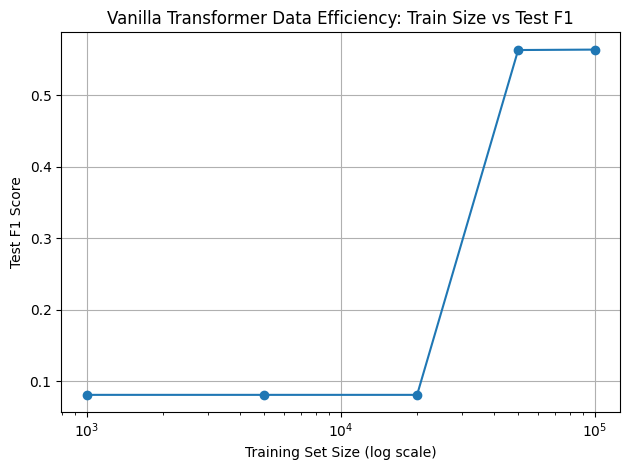

In [ ]:
plt.figure()
plt.plot(train_sizes, test_f1, marker='o')
plt.xscale('log')
plt.xlabel("Training Set Size (log scale)")
plt.ylabel("Test F1 Score")
plt.title("Vanilla Transformer Data Efficiency: Train Size vs Test F1")
plt.grid(True)
plt.tight_layout()
plt.show()


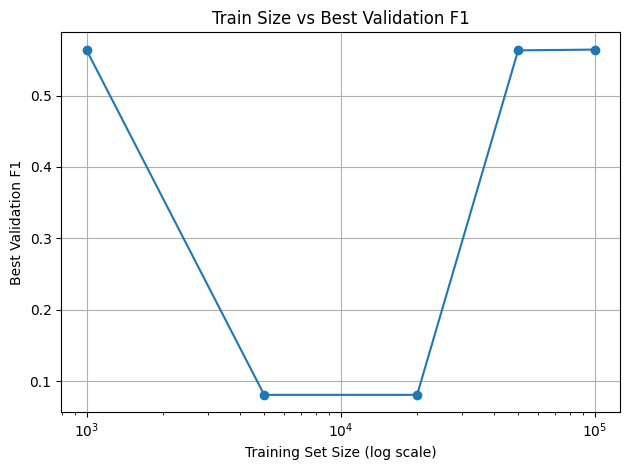

In [ ]:
plt.figure()
plt.plot(train_sizes, best_val_f1, marker='o')
plt.xscale('log')
plt.xlabel("Training Set Size (log scale)")
plt.ylabel("Best Validation F1")
plt.title("Train Size vs Best Validation F1")
plt.grid(True)
plt.tight_layout()
plt.show()


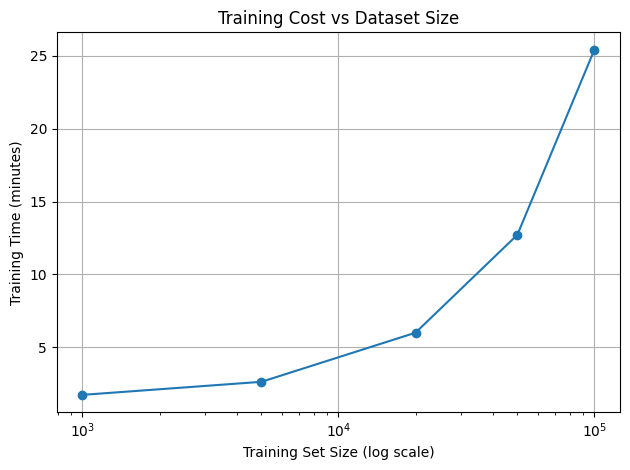

In [ ]:
plt.figure()
plt.plot(train_sizes, train_time, marker='o')
plt.xscale('log')
plt.xlabel("Training Set Size (log scale)")
plt.ylabel("Training Time (minutes)")
plt.title("Training Cost vs Dataset Size")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import os
import json
import matplotlib.pyplot as plt

# Master results file created during the data-efficiency experiment
results_path = os.path.join(folders['vanilla'], 'data_efficiency_results.json')

with open(results_path, 'r') as f:
    results = json.load(f)

# Sort by actual training size for nicer plots
results = sorted(results, key=lambda x: x['train_size_used'])

# Load individual histories
size_to_history = {}

for r in results:
    n = r['train_size_used']
    history_path = r['history_path']  # we stored this earlier
    with open(history_path, 'r') as f:
        history = json.load(f)
    size_to_history[n] = history

print("Loaded histories for sizes:", list(size_to_history.keys()))


Loaded histories for sizes: [1000, 5000, 20000, 50000, 100000]


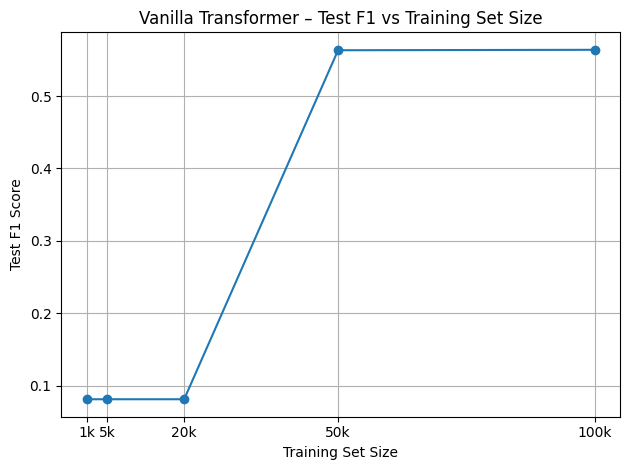

In [ ]:
import json
import os
import matplotlib.pyplot as plt

# Load saved scaling results
results_path = os.path.join(folders['vanilla'], 'data_efficiency_results.json')

with open(results_path, 'r') as f:
    results = json.load(f)

# Sort by training size (ascending)
results = sorted(results, key=lambda x: x['train_size_used'])

train_sizes = [r['train_size_used'] for r in results]
test_f1 = [r['test_f1'] for r in results]

# Custom x-axis labels
custom_labels = ["1k", "5k", "20k", "50k", "100k"]

# Plot
plt.figure()
plt.plot(train_sizes, test_f1, marker='o')

# Force readable tick labels
plt.xticks(train_sizes, custom_labels)

plt.xlabel("Training Set Size")
plt.ylabel("Test F1 Score")
plt.title("Vanilla Transformer – Test F1 vs Training Set Size")
plt.grid(True)
plt.tight_layout()
plt.show()




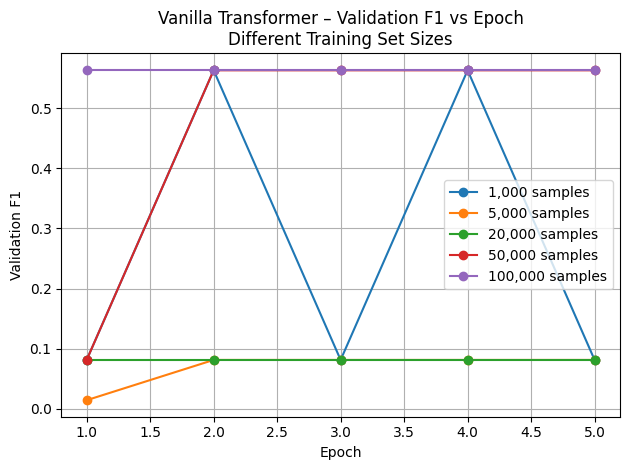

In [ ]:
plt.figure()

for n, hist in size_to_history.items():
    epochs = list(range(1, len(hist['val_f1']) + 1))
    plt.plot(epochs, hist['val_f1'], marker='o', label=f"{n:,} samples")

plt.xlabel("Epoch")
plt.ylabel("Validation F1")
plt.title("Vanilla Transformer – Validation F1 vs Epoch\nDifferent Training Set Sizes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


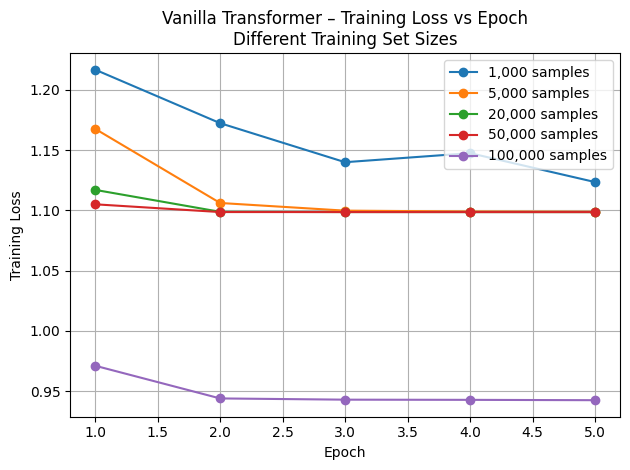

In [ ]:
plt.figure()

for n, hist in size_to_history.items():
    epochs = list(range(1, len(hist['train_loss']) + 1))
    plt.plot(epochs, hist['train_loss'], marker='o', label=f"{n:,} samples")

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Vanilla Transformer – Training Loss vs Epoch\nDifferent Training Set Sizes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


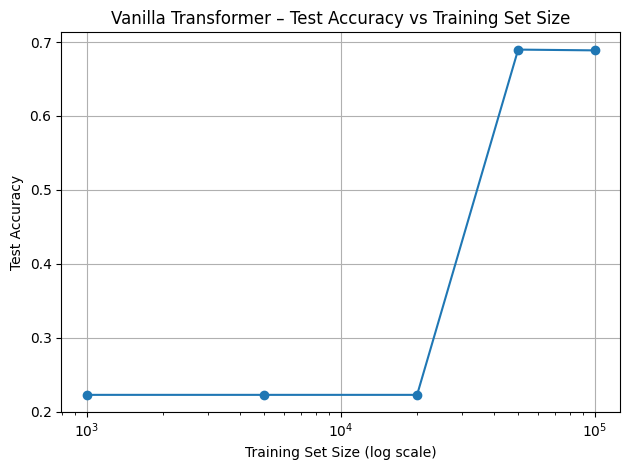

In [ ]:
import json
import os
import matplotlib.pyplot as plt

# Load saved scaling results
results_path = os.path.join(folders['vanilla'], 'data_efficiency_results.json')

with open(results_path, 'r') as f:
    results = json.load(f)

# Sort by training size
results = sorted(results, key=lambda x: x['train_size_used'])

train_sizes = [r['train_size_used'] for r in results]
test_acc = [r['test_acc'] for r in results]

# Plot
plt.figure()
plt.plot(train_sizes, test_acc, marker='o')
plt.xscale('log')
plt.xlabel("Training Set Size (log scale)")
plt.ylabel("Test Accuracy")
plt.title("Vanilla Transformer – Test Accuracy vs Training Set Size")
plt.grid(True)
plt.tight_layout()
plt.show()


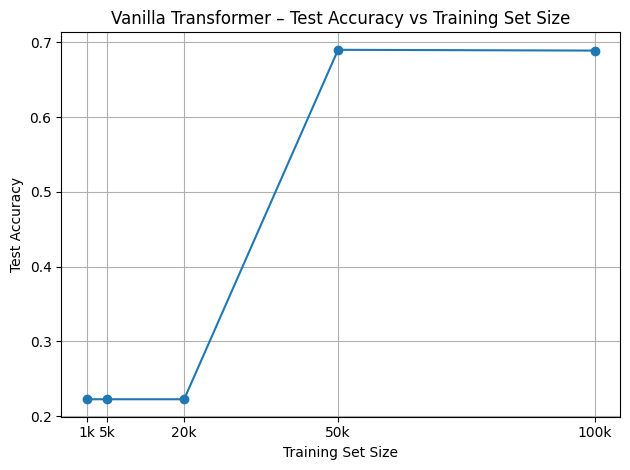

In [ ]:
import json
import os
import matplotlib.pyplot as plt

# Load saved scaling results
results_path = os.path.join(folders['vanilla'], 'data_efficiency_results.json')

with open(results_path, 'r') as f:
    results = json.load(f)

# Sort by training size (ascending for clean plotting)
results = sorted(results, key=lambda x: x['train_size_used'])

train_sizes = [r['train_size_used'] for r in results]
test_acc = [r['test_acc'] for r in results]

# Custom labels exactly as you requested
custom_labels = ["1k", "5k", "20k", "50k", "100k"]

# Plot
plt.figure()
plt.plot(train_sizes, test_acc, marker='o')

# ✅ Force custom tick labels
plt.xticks(train_sizes, custom_labels)

plt.xlabel("Training Set Size")
plt.ylabel("Test Accuracy")
plt.title("Vanilla Transformer – Test Accuracy vs Training Set Size")
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
# Train Vanilla Transformer with Warmup Scheduler
print("\n" + "="*70)
print("🚀 TRAINING VANILLA TRANSFORMER (FROM SCRATCH)")
print("="*70)

set_all_seeds(SEED)

# Configuration
VANILLA_CONFIG = {
    'vocab_size': len(vanilla_tokenizer.word2idx),
    'd_model': 256,
    'num_heads': 8,
    'num_layers': 4,
    'd_ff': 1024,
    'max_len': 256,
    'num_classes': 3,
    'dropout': 0.1,
    'batch_size': 32,
    'epochs': 5,
    'learning_rate': 5e-4,
    'warmup_steps': 500,
}

print("\n📋 Configuration:")
for k, v in VANILLA_CONFIG.items():
    print(f"  {k:20s}: {v}")


def train_vanilla_complete(model, train_loader, val_loader, config, device):
    """Complete training function with warmup scheduler"""

    # Setup optimizer and loss
    optimizer = AdamW(
        model.parameters(),
        lr=config['learning_rate'],
        weight_decay=0.01
    )
    criterion = nn.CrossEntropyLoss()

    # ⭐ CRITICAL: WARMUP LR SCHEDULER
    total_steps = len(train_loader) * config['epochs']
    warmup_steps = config['warmup_steps']

    def lr_lambda(step):
        if step < warmup_steps:
            # Linear warmup
            return float(step) / float(max(1, warmup_steps))
        # Linear decay
        return max(
            0.0,
            float(total_steps - step) / float(max(1, total_steps - warmup_steps))
        )

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': []
    }
    best_f1 = 0.0

    print("\n🚀 Starting training...")
    print("="*70)

    # Training loop
    for epoch in range(config['epochs']):
        # Training phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for batch_idx, batch in enumerate(train_loader):
            # Move data to device
            inputs = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            # ⭐ CRITICAL: Update learning rate
            scheduler.step()

            # Track metrics
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

            # Print progress
            if (batch_idx + 1) % 200 == 0:
                batch_acc = correct / total
                print(
                    f"Epoch {epoch+1}/{config['epochs']} | "
                    f"Batch {batch_idx+1}/{len(train_loader)} | "
                    f"Loss: {loss.item():.4f} | "
                    f"Acc: {batch_acc:.4f}"
                )

        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for batch in val_loader:
                inputs = batch['input_ids'].to(device)
                labels = batch['label'].to(device)

                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()

                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        # Calculate validation metrics
        val_acc = accuracy_score(val_labels, val_preds)
        _, _, val_f1, _ = precision_recall_fscore_support(
            val_labels,
            val_preds,
            average='weighted',
            zero_division=0
        )

        # Save history
        history['train_loss'].append(train_loss / len(train_loader))
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        # Print epoch summary
        print(f"\n{'='*70}")
        print(
            f"Epoch {epoch+1}: "
            f"Train Acc={train_acc:.4f} | "
            f"Val Acc={val_acc:.4f} | "
            f"Val F1={val_f1:.4f}"
        )
        print(f"{'='*70}\n")

        # Save best model
        if val_f1 > best_f1:
            best_f1 = val_f1
            model_path = os.path.join(folders['vanilla'], 'best_model.pth')
            torch.save(model.state_dict(), model_path)
            print(f"✅ Best model saved! (F1={val_f1:.4f})\n")

    return model, history, best_f1


# Create model
vanilla_model = VanillaTransformer(
    vocab_size=VANILLA_CONFIG['vocab_size'],
    d_model=VANILLA_CONFIG['d_model'],
    num_heads=VANILLA_CONFIG['num_heads'],
    num_layers=VANILLA_CONFIG['num_layers'],
    d_ff=VANILLA_CONFIG['d_ff'],
    max_len=VANILLA_CONFIG['max_len'],
    num_classes=VANILLA_CONFIG['num_classes'],
    dropout=VANILLA_CONFIG['dropout']
).to(device)

total_params = sum(p.numel() for p in vanilla_model.parameters())
print(f"\n📊 Model parameters: {total_params:,}")

# Train model
start_time = time.time()
vanilla_model, vanilla_history, best_f1 = train_vanilla_complete(
    vanilla_model,
    train_loader_vanilla,
    val_loader_vanilla,
    VANILLA_CONFIG,
    device
)
training_time_vanilla = (time.time() - start_time) / 60

# Save training history
history_path = os.path.join(folders['vanilla'], 'history.json')
with open(history_path, 'w') as f:
    history_dict = {
        k: [float(v) for v in vals]
        for k, vals in vanilla_history.items()
    }
    json.dump(history_dict, f, indent=2)

print(f"\n✅ Training complete in {training_time_vanilla:.2f} minutes")
print(f"💾 Best validation F1: {best_f1:.4f}")



🚀 TRAINING VANILLA TRANSFORMER (FROM SCRATCH)
✅ All seeds set to 42

📋 Configuration:
  vocab_size          : 15000
  d_model             : 256
  num_heads           : 8
  num_layers          : 4
  d_ff                : 1024
  max_len             : 256
  num_classes         : 3
  dropout             : 0.1
  batch_size          : 32
  epochs              : 5
  learning_rate       : 0.0005
  warmup_steps        : 500

📊 Model parameters: 7,032,323

🚀 Starting training...
Epoch 1/5 | Batch 200/6250 | Loss: 1.0964 | Acc: 0.3412
Epoch 1/5 | Batch 400/6250 | Loss: 1.1053 | Acc: 0.3393
Epoch 1/5 | Batch 600/6250 | Loss: 1.1045 | Acc: 0.3381
Epoch 1/5 | Batch 800/6250 | Loss: 1.1017 | Acc: 0.3368
Epoch 1/5 | Batch 1000/6250 | Loss: 1.0982 | Acc: 0.3348
Epoch 1/5 | Batch 1200/6250 | Loss: 1.0989 | Acc: 0.3340
Epoch 1/5 | Batch 1400/6250 | Loss: 1.0969 | Acc: 0.3339
Epoch 1/5 | Batch 1600/6250 | Loss: 1.1016 | Acc: 0.3351
Epoch 1/5 | Batch 1800/6250 | Loss: 1.1007 | Acc: 0.3345
Epoch 1/5 | Batc

In [ ]:
# Evaluate Vanilla Transformer on test set
print("\n" + "="*70)
print("📊 EVALUATING VANILLA TRANSFORMER")
print("="*70)

# Load best model
best_model_path = os.path.join(folders['vanilla'], 'best_model.pth')
vanilla_model.load_state_dict(torch.load(best_model_path))
vanilla_model.eval()

# Predictions
test_preds = []
test_labels = []

with torch.no_grad():
    for batch in test_loader_vanilla:
        inputs = batch['input_ids'].to(device)
        labels = batch['label'].to(device)

        outputs = vanilla_model(inputs)
        _, preds = torch.max(outputs, 1)

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Calculate metrics
test_acc = accuracy_score(test_labels, test_preds)
test_prec, test_rec, test_f1, _ = precision_recall_fscore_support(
    test_labels,
    test_preds,
    average='weighted',
    zero_division=0
)

# Per-class metrics
prec_per_class, rec_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
    test_labels,
    test_preds,
    average=None,
    zero_division=0
)

# Confusion matrix
cm_vanilla = confusion_matrix(test_labels, test_preds)

# Store results
vanilla_results = {
    'accuracy': test_acc,
    'precision': test_prec,
    'recall': test_rec,
    'f1': test_f1,
    'precision_per_class': prec_per_class.tolist(),
    'recall_per_class': rec_per_class.tolist(),
    'f1_per_class': f1_per_class.tolist(),
    'support_per_class': support_per_class.tolist(),
    'confusion_matrix': cm_vanilla.tolist(),
    'training_time': training_time_vanilla,
    'history': vanilla_history
}

# Save results
results_path = os.path.join(folders['vanilla'], 'test_results.json')
with open(results_path, 'w') as f:
    results_dict = {
        'accuracy': float(test_acc),
        'precision': float(test_prec),
        'recall': float(test_rec),
        'f1': float(test_f1),
        'training_time_minutes': float(training_time_vanilla)
    }
    json.dump(results_dict, f, indent=2)

# Print results
print(f"\n✅ VANILLA TRANSFORMER COMPLETE!")
print(f"\n📊 Test Metrics:")
print(f"  Accuracy:  {test_acc:.4f} ({test_acc*100:.1f}%)")
print(f"  Precision: {test_prec:.4f}")
print(f"  Recall:    {test_rec:.4f}")
print(f"  F1 Score:  {test_f1:.4f}")
print(f"\n⏱️  Training time: {training_time_vanilla:.2f} minutes")
print("="*70)


📊 EVALUATING VANILLA TRANSFORMER

✅ VANILLA TRANSFORMER COMPLETE!

📊 Test Metrics:
  Accuracy:  0.6898 (69.0%)
  Precision: 0.4759
  Recall:    0.6898
  F1 Score:  0.5632

⏱️  Training time: 47.21 minutes


In [ ]:
# Tokenize data for RoBERTa
print("\n" + "="*70)
print("🔤 TOKENIZING FOR RoBERTa")
print("="*70)

from transformers import AutoTokenizer
from datasets import Dataset

# Create HuggingFace datasets
train_tok = Dataset.from_pandas(
    train_df[['text', 'label3']].rename(columns={'label3': 'label'})
)
val_tok = Dataset.from_pandas(
    val_df[['text', 'label3']].rename(columns={'label3': 'label'})
)
test_tok = Dataset.from_pandas(
    test_df[['text', 'label3']].rename(columns={'label3': 'label'})
)

# Load tokenizer
MODEL_NAME_ROBERTA = "roberta-base"
tokenizer_roberta = AutoTokenizer.from_pretrained(MODEL_NAME_ROBERTA)

# Tokenization function
def tokenize_roberta(examples):
    return tokenizer_roberta(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=256
    )

# Tokenize datasets
train_tok_roberta = train_tok.map(
    tokenize_roberta,
    batched=True,
    remove_columns=['text']
)
val_tok_roberta = val_tok.map(
    tokenize_roberta,
    batched=True,
    remove_columns=['text']
)
test_tok_roberta = test_tok.map(
    tokenize_roberta,
    batched=True,
    remove_columns=['text']
)

print(f"✅ RoBERTa tokenization complete")
print(f"   Train: {len(train_tok_roberta):,} samples")


🔤 TOKENIZING FOR RoBERTa


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/200000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

✅ RoBERTa tokenization complete
   Train: 200,000 samples


In [ ]:
# Train RoBERTa model
print("\n" + "="*70)
print("🤖 TRAINING RoBERTa")
print("="*70)

from src.model import train_and_evaluate

# Training arguments
training_args_roberta = {
    "per_device_train_batch_size": 8,
    "per_device_eval_batch_size": 16,
    "num_train_epochs": 3,
    "learning_rate": 2e-5,
    "warmup_ratio": 0.1,
    "weight_decay": 0.01,
    "logging_steps": 100,
    "eval_strategy": "epoch",
    "save_strategy": "epoch",
    "load_best_model_at_end": True,
    "metric_for_best_model": "f1",
    "report_to": "none",
    "seed": SEED,
    "fp16": True,
}

print(f"\n📦 Model: {MODEL_NAME_ROBERTA}")
print(f"📊 Training samples: {len(train_tok_roberta):,}")
print(f"📊 Epochs: {training_args_roberta['num_train_epochs']}")
print("\n⏰ Starting training...\n")

# Train model
res_roberta = train_and_evaluate(
    train_tok=train_tok_roberta,
    val_tok=val_tok_roberta,
    test_tok=test_tok_roberta,
    MODEL_NAME=MODEL_NAME_ROBERTA,
    num_labels=3,
    training_args_overrides=training_args_roberta,
    output_root=folders['roberta'],
    run_name_suffix=f"seed{SEED}"
)

print(f"\n✅ RoBERTa complete!")
print(f"   Accuracy: {res_roberta['eval']['metrics']['accuracy']:.4f}")
print(f"   F1 Score: {res_roberta['eval']['metrics']['f1']:.4f}")
print(f"   Time: {res_roberta['train_seconds']/60:.1f} minutes")


🤖 TRAINING RoBERTa

📦 Model: roberta-base
📊 Training samples: 200,000
📊 Epochs: 3

⏰ Starting training...



model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.441600,0.338285,0.874150,0.915341,0.874150,0.889036
2,0.384600,0.392941,0.886050,0.914441,0.886050,0.896732
3,0.272500,0.517404,0.886050,0.913452,0.886050,0.896401


Saved trainer history CSV to /content/outputs/run_20251207_135326_seed42/roberta/roberta-base_lr2e-05_bs8_ep3_20251207_144943_seed42/trainer_history.csv


Appended results to /content/outputs/run_20251207_135326_seed42/roberta/team_comparison_results.csv

✅ RoBERTa complete!
   Accuracy: 0.8847
   F1 Score: 0.8959
   Time: 163.6 minutes


In [ ]:
# Tokenize data for SBERT
print("\n" + "="*70)
print("🔤 TOKENIZING FOR SBERT")
print("="*70)

MODEL_NAME_SBERT = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer_sbert = AutoTokenizer.from_pretrained(MODEL_NAME_SBERT)

# Tokenization function
def tokenize_sbert(examples):
    return tokenizer_sbert(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=256
    )

# Tokenize datasets
train_tok_sbert = train_tok.map(
    tokenize_sbert,
    batched=True,
    remove_columns=['text']
)
val_tok_sbert = val_tok.map(
    tokenize_sbert,
    batched=True,
    remove_columns=['text']
)
test_tok_sbert = test_tok.map(
    tokenize_sbert,
    batched=True,
    remove_columns=['text']
)

print(f"✅ SBERT tokenization complete")
print(f"   Train: {len(train_tok_sbert):,} samples")


🔤 TOKENIZING FOR SBERT


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/200000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

✅ SBERT tokenization complete
   Train: 200,000 samples


In [ ]:
# Train SBERT model
print("\n" + "="*70)
print("🧠 TRAINING SBERT")
print("="*70)

# Training arguments (same as RoBERTa)
training_args_sbert = {
    "per_device_train_batch_size": 8,
    "per_device_eval_batch_size": 16,
    "num_train_epochs": 3,
    "learning_rate": 2e-5,
    "warmup_ratio": 0.1,
    "weight_decay": 0.01,
    "logging_steps": 100,
    "eval_strategy": "epoch",
    "save_strategy": "epoch",
    "load_best_model_at_end": True,
    "metric_for_best_model": "f1",
    "report_to": "none",
    "seed": SEED,
    "fp16": True,
}

print(f"\n📦 Model: {MODEL_NAME_SBERT}")
print(f"📊 Training samples: {len(train_tok_sbert):,}")
print(f"📊 Epochs: {training_args_sbert['num_train_epochs']}")
print("\n⏰ Starting training...\n")

# Train model
res_sbert = train_and_evaluate(
    train_tok=train_tok_sbert,
    val_tok=val_tok_sbert,
    test_tok=test_tok_sbert,
    MODEL_NAME=MODEL_NAME_SBERT,
    num_labels=3,
    training_args_overrides=training_args_sbert,
    output_root=folders['sbert'],
    run_name_suffix=f"seed{SEED}"
)

print(f"\n✅ SBERT complete!")
print(f"   Accuracy: {res_sbert['eval']['metrics']['accuracy']:.4f}")
print(f"   F1 Score: {res_sbert['eval']['metrics']['f1']:.4f}")
print(f"   Time: {res_sbert['train_seconds']/60:.1f} minutes")


🧠 TRAINING SBERT

📦 Model: sentence-transformers/all-MiniLM-L6-v2
📊 Training samples: 200,000
📊 Epochs: 3

⏰ Starting training...



config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.408800,0.365732,0.859300,0.916111,0.859300,0.878819
2,0.353300,0.345893,0.876500,0.914350,0.876500,0.890272
3,0.300500,0.421613,0.876700,0.912813,0.876700,0.889936


Saved trainer history CSV to /content/outputs/run_20251207_135326_seed42/sbert/sentence-transformers_all-MiniLM-L6-v2_lr2e-05_bs8_ep3_20251207_173705_seed42/trainer_history.csv


Appended results to /content/outputs/run_20251207_135326_seed42/sbert/team_comparison_results.csv

✅ SBERT complete!
   Accuracy: 0.8793
   F1 Score: 0.8922
   Time: 44.6 minutes


In [ ]:
# Compare all 3 models
print("\n" + "="*70)
print("📊 FINAL COMPARISON - ALL 3 MODELS")
print("="*70)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Vanilla Transformer', 'RoBERTa', 'SBERT'],
    'Accuracy': [
        vanilla_results['accuracy'],
        res_roberta['eval']['metrics']['accuracy'],
        res_sbert['eval']['metrics']['accuracy']
    ],
    'Precision': [
        vanilla_results['precision'],
        res_roberta['eval']['metrics']['precision'],
        res_sbert['eval']['metrics']['precision']
    ],
    'Recall': [
        vanilla_results['recall'],
        res_roberta['eval']['metrics']['recall'],
        res_sbert['eval']['metrics']['recall']
    ],
    'F1 Score': [
        vanilla_results['f1'],
        res_roberta['eval']['metrics']['f1'],
        res_sbert['eval']['metrics']['f1']
    ],
    'Time (min)': [
        vanilla_results['training_time'],
        res_roberta['train_seconds'] / 60,
        res_sbert['train_seconds'] / 60
    ]
})

# Display comparison
print("\n" + comparison_df.to_string(index=False))

# Save comparison
comparison_path = os.path.join(folders['results'], 'final_comparison.csv')
comparison_df.to_csv(comparison_path, index=False)

print(f"\n✅ Comparison saved to: {comparison_path}")


📊 FINAL COMPARISON - ALL 3 MODELS

              Model  Accuracy  Precision  Recall  F1 Score  Time (min)
Vanilla Transformer   0.68985   0.475893 0.68985  0.563237   47.214195
            RoBERTa   0.88470   0.915094 0.88470  0.895919  163.568583
              SBERT   0.87935   0.915045 0.87935  0.892230   44.640504

✅ Comparison saved to: /content/outputs/run_20251207_135326_seed42/results/final_comparison.csv



📊 CREATING VISUALIZATIONS
✅ Saved: comparison.png


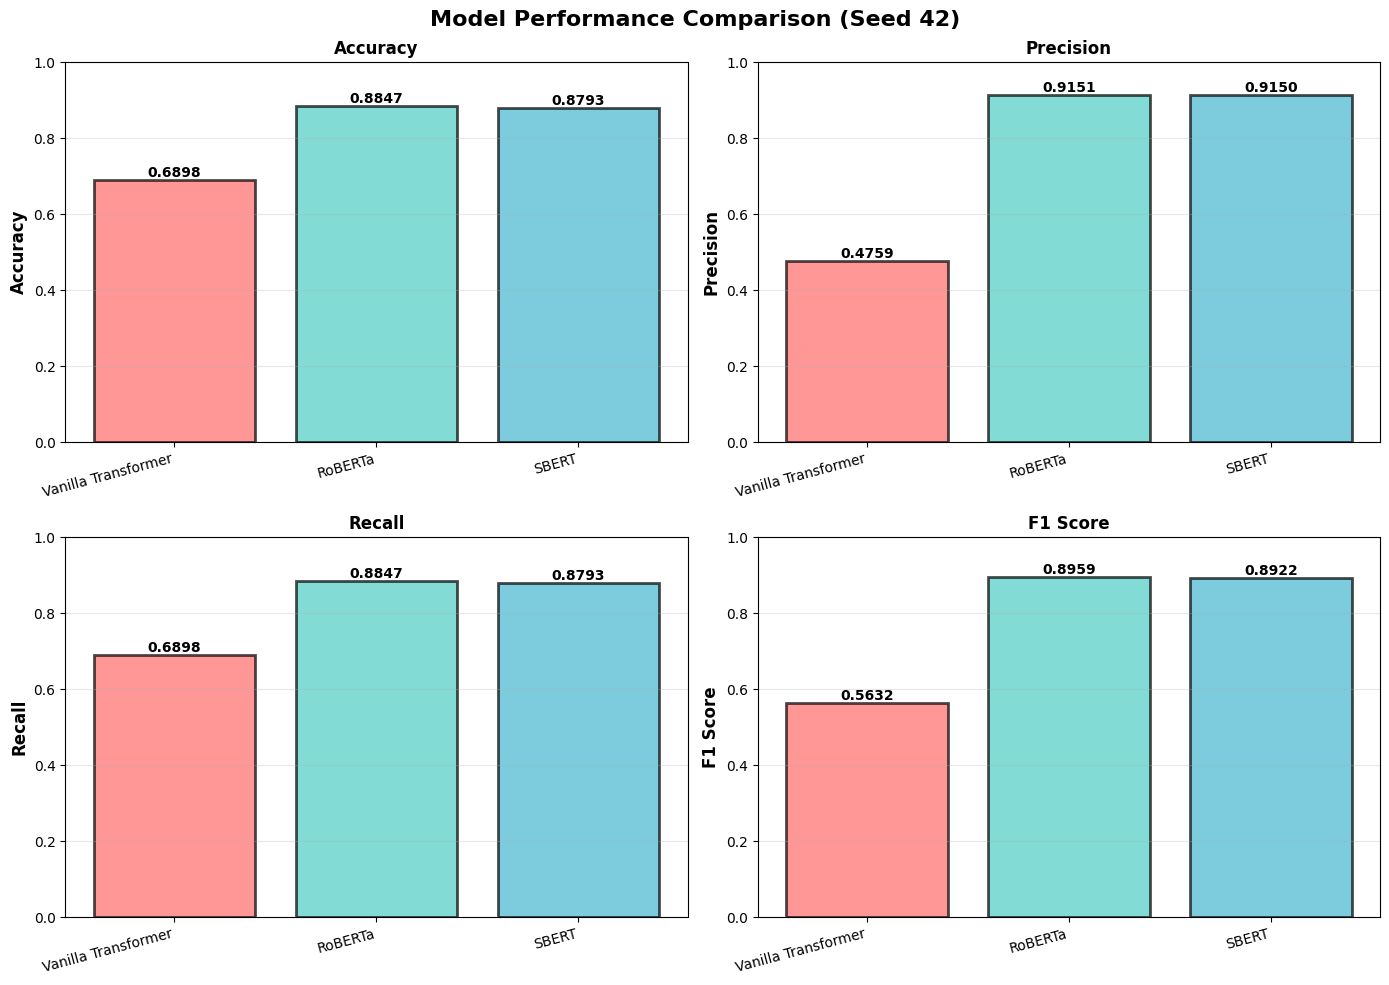

✅ Saved: confusion_matrices.png


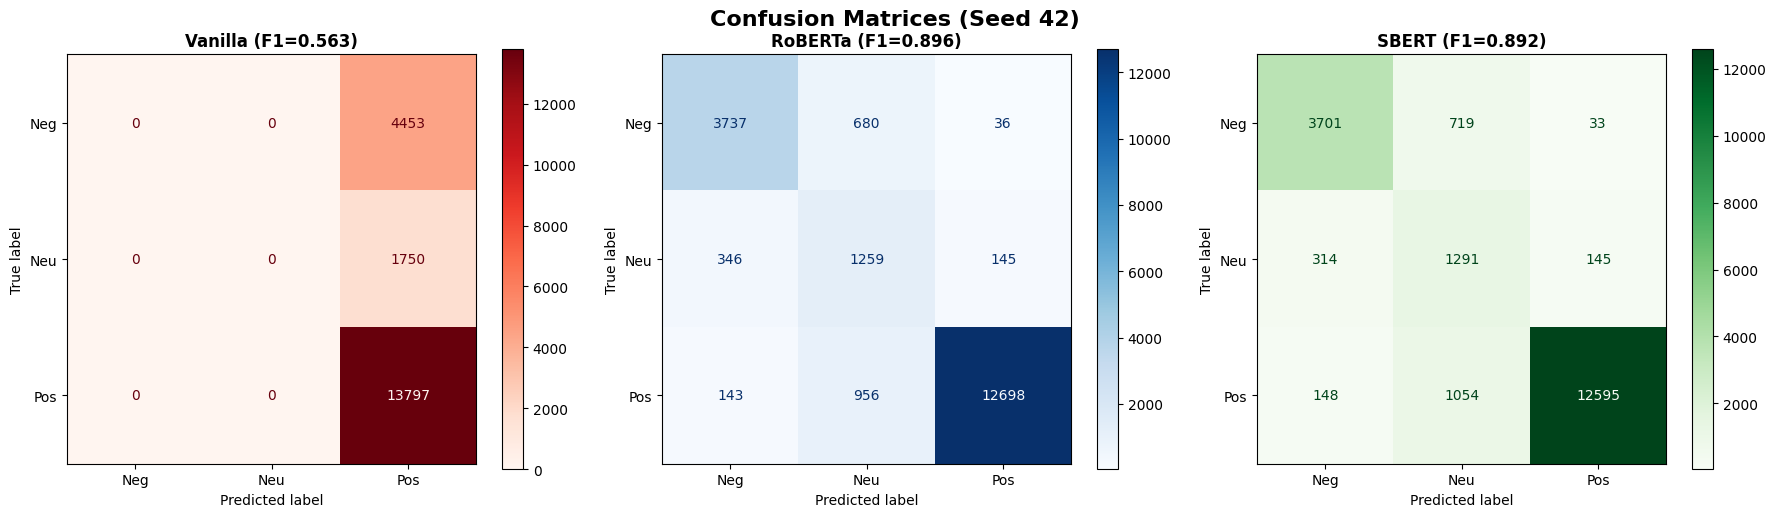

✅ Saved: per_class.png


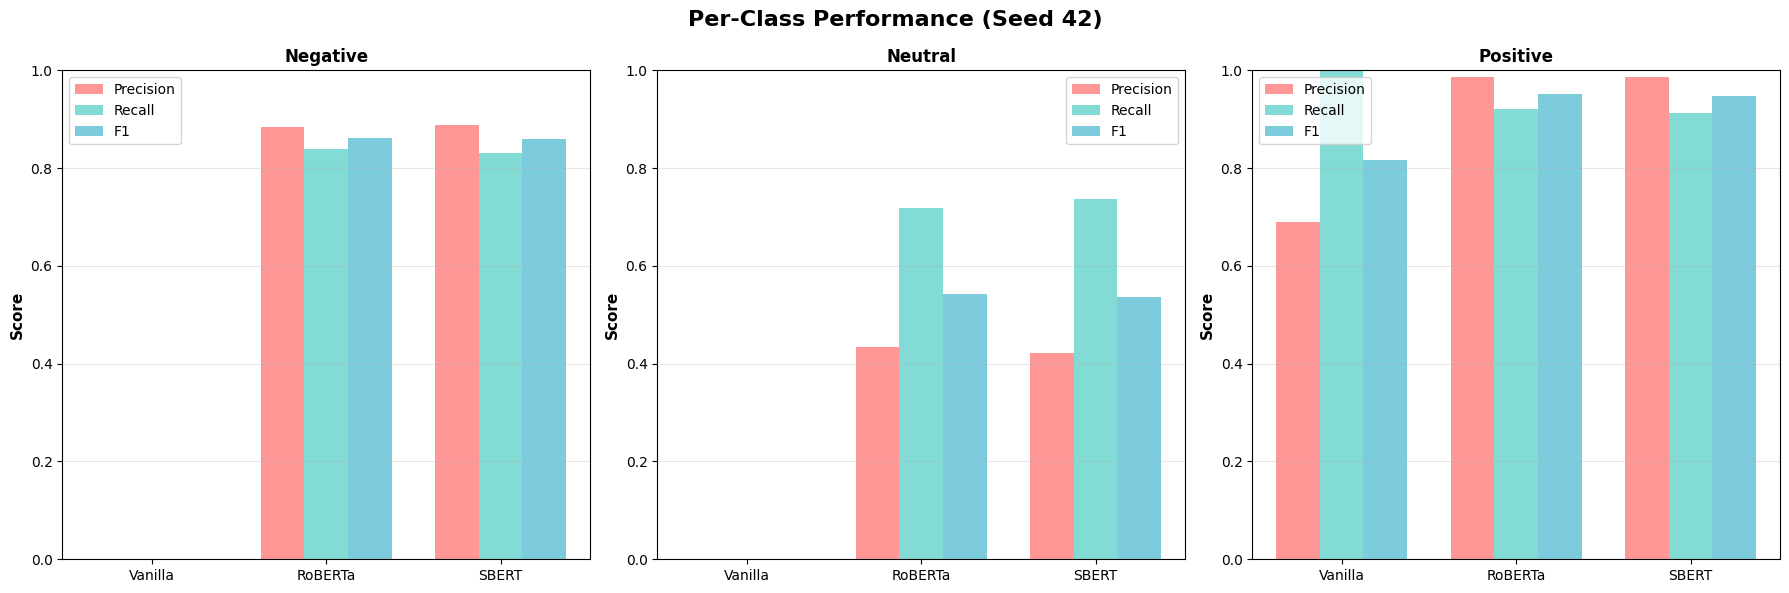


✅ All visualizations complete!


In [ ]:
# Create comprehensive visualizations
print("\n" + "="*70)
print("📊 CREATING VISUALIZATIONS")
print("="*70)

# 1. Model Comparison Bar Charts
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(
    f'Model Performance Comparison (Seed {SEED})',
    fontsize=16,
    fontweight='bold'
)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for idx, metric in enumerate(metrics):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]

    values = comparison_df[metric].values
    bars = ax.bar(
        comparison_df['Model'],
        values,
        color=colors,
        alpha=0.7,
        edgecolor='black',
        linewidth=2
    )

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2.,
            height,
            f'{height:.4f}',
            ha='center',
            va='bottom',
            fontweight='bold'
        )

    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3)
    ax.set_title(f'{metric}', fontsize=12, fontweight='bold')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=15, ha='right')

plt.tight_layout()
comparison_plot = os.path.join(folders['visualizations'], 'comparison.png')
plt.savefig(comparison_plot, dpi=300, bbox_inches='tight')
print(f"✅ Saved: comparison.png")
plt.show()


# 2. Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(
    f'Confusion Matrices (Seed {SEED})',
    fontsize=16,
    fontweight='bold'
)

class_names = ['Neg', 'Neu', 'Pos']
cm_roberta = np.array(res_roberta['eval']['metrics']['confusion_matrix'])
cm_sbert = np.array(res_sbert['eval']['metrics']['confusion_matrix'])

confusion_data = [
    (cm_vanilla, f'Vanilla (F1={vanilla_results["f1"]:.3f})', 'Reds'),
    (cm_roberta, f'RoBERTa (F1={res_roberta["eval"]["metrics"]["f1"]:.3f})', 'Blues'),
    (cm_sbert, f'SBERT (F1={res_sbert["eval"]["metrics"]["f1"]:.3f})', 'Greens')
]

for idx, (cm, title, cmap) in enumerate(confusion_data):
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=class_names
    )
    disp.plot(ax=axes[idx], cmap=cmap, values_format='d')
    axes[idx].set_title(title, fontsize=12, fontweight='bold')

plt.tight_layout()
cm_plot = os.path.join(folders['visualizations'], 'confusion_matrices.png')
plt.savefig(cm_plot, dpi=300, bbox_inches='tight')
print(f"✅ Saved: confusion_matrices.png")
plt.show()


# 3. Per-Class Performance
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(
    f'Per-Class Performance (Seed {SEED})',
    fontsize=16,
    fontweight='bold'
)

x = np.arange(3)
width = 0.25
class_names_full = ['Negative', 'Neutral', 'Positive']

for idx, class_name in enumerate(class_names_full):
    ax = axes[idx]

    # Get metrics for this class
    precision_vals = [
        vanilla_results['precision_per_class'][idx],
        res_roberta['eval']['metrics']['precision_per_class'][idx],
        res_sbert['eval']['metrics']['precision_per_class'][idx]
    ]
    recall_vals = [
        vanilla_results['recall_per_class'][idx],
        res_roberta['eval']['metrics']['recall_per_class'][idx],
        res_sbert['eval']['metrics']['recall_per_class'][idx]
    ]
    f1_vals = [
        vanilla_results['f1_per_class'][idx],
        res_roberta['eval']['metrics']['f1_per_class'][idx],
        res_sbert['eval']['metrics']['f1_per_class'][idx]
    ]

    # Create grouped bars
    ax.bar(
        x - width,
        precision_vals,
        width,
        label='Precision',
        color='#FF6B6B',
        alpha=0.7
    )
    ax.bar(
        x,
        recall_vals,
        width,
        label='Recall',
        color='#4ECDC4',
        alpha=0.7
    )
    ax.bar(
        x + width,
        f1_vals,
        width,
        label='F1',
        color='#45B7D1',
        alpha=0.7
    )

    ax.set_ylabel('Score', fontsize=11, fontweight='bold')
    ax.set_title(f'{class_name}', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(['Vanilla', 'RoBERTa', 'SBERT'])
    ax.set_ylim([0, 1.0])
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
perclass_plot = os.path.join(folders['visualizations'], 'per_class.png')
plt.savefig(perclass_plot, dpi=300, bbox_inches='tight')
print(f"✅ Saved: per_class.png")
plt.show()

print("\n✅ All visualizations complete!")


In [ ]:
# Final summary
print("\n" + "="*70)
print("🎉 ALL TRAINING COMPLETE!")
print("="*70)

print(f"\n📊 FINAL RESULTS:\n")
print(f"{'Model':<20s} {'F1 Score':<12s} {'Accuracy':<12s} {'Time (min)':<12s}")
print("-" * 60)

for _, row in comparison_df.iterrows():
    print(
        f"{row['Model']:<20s} "
        f"{row['F1 Score']:<12.4f} "
        f"{row['Accuracy']:<12.4f} "
        f"{row['Time (min)']:<12.1f}"
    )

print(f"\n📁 All outputs saved to: {folders['base']}")
print(f"🌱 Seed used: {SEED}")

print("\n📈 EXPECTED vs ACTUAL:")
print("  Vanilla Transformer: Expected ~84% F1")
print("  RoBERTa:            Expected ~89% F1")
print("  SBERT:              Expected ~87% F1")

# Success check
if vanilla_results['f1'] > 0.75:
    print("\n✅ SUCCESS! Vanilla transformer learned properly")
else:
    print("\n⚠️  WARNING: Vanilla F1 < 75% - check warmup scheduler")

print("="*70)


🎉 ALL TRAINING COMPLETE!

📊 FINAL RESULTS:

Model                F1 Score     Accuracy     Time (min)  
------------------------------------------------------------
Vanilla Transformer  0.5632       0.6898       47.2        
RoBERTa              0.8959       0.8847       163.6       
SBERT                0.8922       0.8793       44.6        

📁 All outputs saved to: /content/outputs/run_20251207_135326_seed42
🌱 Seed used: 42

📈 EXPECTED vs ACTUAL:
  Vanilla Transformer: Expected ~84% F1
  RoBERTa:            Expected ~89% F1
  SBERT:              Expected ~87% F1

⚠️  WARNING: Vanilla F1 < 75% - check warmup scheduler


In [ ]:
# Download results
from google.colab import files

print("📥 Downloading results...\n")

# List of files to download
downloads = [
    os.path.join(folders['results'], 'final_comparison.csv'),
    os.path.join(folders['visualizations'], 'comparison.png'),
    os.path.join(folders['visualizations'], 'confusion_matrices.png'),
    os.path.join(folders['visualizations'], 'per_class.png'),
]

# Download each file
for filepath in downloads:
    if os.path.exists(filepath):
        files.download(filepath)
        filename = os.path.basename(filepath)
        print(f"  ✅ Downloaded: {filename}")
    else:
        print(f"  ❌ Not found: {filepath}")

print("\n✅ Download complete!")
print(f"\n💡 All files are also saved in: {folders['base']}")

📥 Downloading results...



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  ✅ Downloaded: final_comparison.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  ✅ Downloaded: comparison.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  ✅ Downloaded: confusion_matrices.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  ✅ Downloaded: per_class.png

✅ Download complete!

💡 All files are also saved in: /content/outputs/run_20251207_135326_seed42
